# ESS: Analysing and interpreting FDEM data
---
# 0 - Introduction
In this notebook you will explore FDEM data in a more in depth way, and relate the outcomes to specific soil properties. Hereby, you will combine geophysical modelling (inversion) with pedophysical modelling, alongside relating specific target properties to the FDEM outcomes in a more stochastic way. 

This notebook consists of Markdown (text) cells, such as this one, and code cells like the one below. Each code cell is numbered for reference. The first code cell below is **_code cell 0.0_**. Running that cell and **_code cell 0.1_**  installs the required packages in Google Colaboratory, and subsequently import all required packages into the workspace.

There is a lot of Python code in this notebook. However, while you are free to modify the code as you want, in cases where you have to perform data analyses, the part of the code where you have to modify variables, or write functions, always appears above a commented line of asterisks, like this: `# ******* `. The part below the asterisk line is where the rest of the code is written that is required to perform the operation, but where to fulfill the practicum you are not required to change anything.

If no asterisk line is present in a code cell, this means you can simply run the code cell without changing anything to get the output.

In [ ]:
# 0.0: Install required packages in Google Colaboratory
# -----------------------------------------------------
'''
installs the following packages:
  - emagpy: package to analyse and invert FDEM data
  - rasterio: package to handle and manipulate geospatial raster data
'''
!pip install emagpy
!pip install geopandas
!pip install rasterio

In [ ]:
# 0.1: Import packages into workspace
# -----------------------------------------------------
'''
Import the required modules to run all code in this notebook.
'''
# General utility modules
import os
import warnings
import re

# Modules for geopunt data visualisation
from IPython.display import HTML
from IPython.core.display import display
from ipywidgets import widgets, HBox

# Data visualisation, manipulation, and analysis
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.path
from matplotlib.backends.backend_pdf import PdfPages
from scipy.spatial import cKDTree
import scipy.stats
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.optimize import root

# Geospatial data manipulation and raster operations
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.ndimage import gaussian_filter

from shapely.geometry import Point

# Electromagnetic induction data inversion package
from emagpy import Problem

%matplotlib inline

### Field dataset - Testfield Proefhoeve Bottelaere [Vijverhoek, Oosterzele]

The key dataset you will work with in this notebook, is the frequency-domain electromagnetic induction (FDEM) dataset that was collected at our testsite on April 28, 2023. Data were collected with a Dualem-21S. Based on the soil map, soil texture in the test site ranges from sandy loam to clay. WRB soil groups are Cambisols (Eutric Stagnic Cambisols (Loamic)) and Stagnosols (Dystric Retic Stagnosols (Loamic)), both are generally Ruptic (referring to the occurrence of two different source materials, in this case aeolian sand/loess over Tertiary clay). You can explore the soil map, along with the WRB classification, in **_code cell 0.2_**.

The data you have are collected with a FDEM instrument with the following specifications:
- operating frequency: 9000 Hz
- coil geometries:
    1. three coil pairs in HCP mode with Rx at 0.5 m (HCP0.5), 1.0 m (HCP2.1), 2.0 m (HCP2.0) from Tx.
    2. three coil pairs in PRP mode with Rx at 0.6 m (PRP0.6), 1.1 m (PRP1.1), 2.1 m (PRP2.1) from Tx.
- output: QP data as LIN ECa [mS/m], IP data as field intensity [ppt].

Table 1 below lists all columns of the FDEM datasets, and explains their datatype.

> 
>|Column name|datatype|
>|-----------|--------|
>| *x* | easting [m]|
>| *y* | northing [m]|
>| *z* | elevation [m]|
>| *t* | timestamp [s]|
>| *HCP0.5* | 0.5 m HCP LIN ECa data [mS/m]|
>| *PRP0.6* | 0.6 m PRP LIN ECa data [mS/m]|
>| *HCP1.0* | 1.0 m HCP LIN ECa data [mS/m]|
>| *PRP1.1* | 1.1 m PRP LIN ECa data [mS/m]|
>| *HCP2.0* | 2.0 m HCP LIN ECa data [mS/m]|
>| *PRP2.1* | 2.1 m PRP LIN ECa data [mS/m]|
>| *HCP0.5_inph* | 0.5 m HCP inphase data [ppt]|
>| *PRP0.6_inph* | 0.6 m PRP inphase data [ppt]|
>| *HCP1.0_inph* | 1.0 m HCP inphase data [ppt]|
>| *PRP1.1_inph* | 1.1 m PRP inphase data [ppt]|
>| *HCP2.0_inph* | 2.0 m HCP inphase data [ppt]|
>| *PRP2.1_inph* | 2.1 m PRP inphase data [ppt]|
>
> *Table 1: overview of FDEM data column names and the datatype these hold.*
>*(The x and y coordinates are presented in meters Belge Lambert 72 (EPSG:31370), and the elevation (z) in meters above sea level.)* 

Basic processing has been performed, which entails:
- accurate georeferencing and projection to Belge Lambert 1972 coordinate system,
- removal of erroneous datapoints (e.g., standstill moments when the survey setup stopped for >5 seconds),
- drift correction (of all IP and QP/ECa datasets).


In [ ]:
# 0.2: Exploring test site geodata from 'geopunt.be'
# --------------------------------------------------

from IPython.display import HTML
from IPython.core.display import display
from ipywidgets import widgets, HBox

airph = '<iframe src="https://www.geopunt.be/embed/d1fa24f5-a258-45b1-887d-8c1f6928a437" width="500" height="600"></iframe>'
soilm = '<iframe src="https://www.geopunt.be/embed/e7d14f05-9d72-4df1-b8ff-4a2b2a9311db" width="500" height="600"></iframe>'

AerialPhoto = widgets.HTML(airph)
SoilMap = widgets.HTML(soilm)

twinbox = HBox([AerialPhoto, SoilMap])
display(twinbox)

### Loading data

In **_code cell 0.3_**, you can load all survey data you have collected during the field practicum. 
These include:
- FDEM_surveydata: full survey dataset of the Bottelare testfield;
- FDEM_transect: extract of the survey dataset along a reference transect. You can use this to test analytical procedures, which you can then deploy across the full survey dataset;
- sampling_data: calibration and validation sample dataset, collected as two independent stratified random sample sets (samples 1 - 10 =  calibration; 11 - 15 =  validation).

The sampling_data dataset includes the x and y coordinates of the samples along with their ID's, and analytical data on:

- bulk density in g/cm^3   (`bd [g/cm3]`);
- volumetric water content in % (`vwc [%]`);
- clay content in %   (`clay [%]`);
- soil organic matter in %   (`SOM [%]`);
- gravimetric water content (`gmc [%]`);
- silt content in %   (`silt [%]`);
- sand content in %   (`sand [%]`);
- porosity [dimensionless]   (`por [-]`);
- total organic carbon in g/kg   (`SOC [g/kg]`);

- hydraprobe volumetric water content in %   (`hydra_vwc [%]`)
- hydraprobe raw EC in mS/m   (`hydra_ec [mS/m]`)
- hydraprobe soil pore water EC in mS/m   (`hydra_ecp [mS/m]`)
- hydraprobe soil temperature in C   (`hydra_tmp [C]`)
- hydraprobe temperature corrected EC in mS/m   (`hydra_ect [mS/m]`)
- hydraprobe dielectric permittivity [dimensionless]   (`hydra_er [-]`).

The column names are shown between the brackets above. 
You can use these to access the desired data values in the `ds` dataframe (e.g., for bulk density, the values are in the `ds['bd [g/cm3]]` column).

**All geospatial datasets are provided in Lambert 1972 coordinates** (EPSG:31370).
At any point, if the dataframe structure is unclear, or you want to see the column names, you can use the built-in functions df.head() or df.columns. You can also simply download the .csv files and open these in excel or your preferred software.  

In [ ]:
# 0.3: Get dataset location
# -------------------------
# store dataset URL's as string variables
FDEM_surveydata = 'https://users.ugent.be/~pjdsmedt/ESS2023/FDEM_2804.csv'
FDEM_transect = 'https://users.ugent.be/~pjdsmedt/ESS2023/FDEM_transect_2804.csv'
samples = 'https://users.ugent.be/~pjdsmedt/ESS2023/samples_combined.csv'

# URL for grid masking file
blank_json = 'https://users.ugent.be/~pjdsmedt/ESS2023/blank.json'

# Create dataframes from datasets
'''
Import datasets as dataframes
-----------------------------
    - df = dataframe with the full FDEM dataset
    - dt = dataframe with the FDEM transect
    - ds = datasframe with the sample data (including analytical data)
    - blank = geojson (polygon) outlining survey extent
'''
df = pd.read_csv(FDEM_surveydata, sep=',', header=0)
dt = pd.read_csv(FDEM_transect, sep=',', header=0)
ds = pd.read_csv(samples, sep=',', header=0)
blank_in = gpd.read_file(blank_json)
blank = blank_in.to_crs('EPSG:31370')

## Pandas dataframe names

As presented in the code cell above, all datasets are loaded as pandas dataframes. You can access the column data through the column names, as is the case throughout this notebook.
If you want to quickly view the column names, just create a code cell, and type the dataframe name with the suffix *.colums* ( like this: `df.columns`) and run the cell, you can run **_code cell 0.4_** as example.

In [ ]:
# 0.4: Printing dataframe column names
# ------------------------------------

""" 
Dataframe names for reference.
- df = dataframe with the full FDEM dataset
- dt = dataframe with the FDEM transect
- ds = datasframe with the sample data (including analytical data)
"""

df.columns # change the dataframe name to visualise its columns

# ******************************************************************** #

# 1. Interpolating and exporting data.

In this notebook, you will work with geospatial data in vector (point) and raster format. To help you along the way to analyse and visualise data, in **_code cell 1.0_**, basic functions to interpolate and export data are given. You can call these functions anywhere in the notebook, as long as you run the following code cell first. 
When working in Google Colaboratory, running the export function anywhere in the notebook will store the exported geotif on your Google Drive.  

**!!! If you export two different datasets with the same filename, the first dataset will be overwritten !!!**

In [ ]:
# 1.0: Functions for interpolating and exporting data
# ----------------------------------------------------

# a. Function to quickly interpolate a scatter dataset to a regular grid.
# -----------------------------------------------------------------------

def interpolate(x, y, z, cell_size, method='nearest', 
                smooth_s = 0, blank=blank):
    """
    Interpolate scatter data to regular grid through selected interpolation 
    method (with scipy.interpolate for simple interpolation).

    The output of this function is a Numpy array that holds the interpolated 
    data (accessed via `datagrid['grid']` in the cell below), alongside 
    the grid's cell size (`datagrid['cell_size']`) and the grid extent 
    (`datagrid['extent']`). The cell size and extent are needed to allow 
    exporting the interpolated data efficiently to a GeoTIF that can be 
    opened in any GIS software such as QGIS. 

    Parameters
    ----------
    x : np.array
        Cartesian GPS x-coordinates.

    y : np.array
        Cartesian GPS y-coordinates.

    z : np.array
        Data points to interpolate.

    cell_size : float
        Grid cell size (m).

    method : str, optional
        Scipy interpolation method ('nearest', 'linear', 'cubic' or 'IDW')

    smooth_s : float, optional
        Smoothing factor to apply a Gaussian filter on the interpolated grid.
        If 0, no smoothing is performed. (Applying smoothing can result 
        in a loss of detail in the interpolated grid.)

    blank : object
        A blank object to mask (clip )interpolation beyond survey bounds.

    Returns
    -------
    grid : np.array
        Array of interpolated and masked grid containing:
        - the interpolated grid (grid['grid'])
        - the grid cell size (grid['cell_size'])
        - the grid extent (grid['extent'])

    """

    # Define an evenly spaced grid over which the dataset values have to be 
    # interpolated
    x_min = x.min()
    x_max = x.max() + cell_size
    y_min = y.min()
    y_max = y.max() + cell_size
    x_vector = np.arange(x_min, x_max, cell_size)
    y_vector = np.arange(y_min, y_max, cell_size)
    extent = (x_vector[0], x_vector[-1], y_vector[0], y_vector[-1])

    xx, yy = np.meshgrid(x_vector, y_vector)
    nx, ny = xx.shape
    coords = np.concatenate((xx.ravel()[np.newaxis].T, 
                        yy.ravel()[np.newaxis].T), 
                        axis=1)

    # Create a mask to blank grid outside surveyed area
    boolean = np.zeros_like(xx)
    boundaries = np.vstack(blank.loc[0, 'geometry'].exterior.coords.xy).T
    bound = boundaries.copy()
    boolean += matplotlib.path.Path(
        bound).contains_points(coords).reshape((nx, ny))
    boolean = np.where(boolean >= 1, True, False)
    mask = np.where(boolean == False, np.nan, 1)
    binary = np.where(boolean == False, 0, 1)
    
    # Fast (and sloppy) interpolation (scipy.interpolate)
    if method in ['nearest','cubic', 'linear']:
        # Interpolate 
        data_grid = griddata(
            np.vstack((x, y)).T, z, (xx, yy), method=method
            ) * mask
    else:
        print('define interpolation method')
    
    if smooth_s > 0:
        data_grid = gaussian_filter(data_grid, sigma=smooth_s)

    # Create a structured array with additional fields for coordinates and cell size
    dtype = [
        ('grid', data_grid.dtype, data_grid.shape),
        ('cell_size', float),
        ('extent', [
            ('x_min', float), 
            ('x_max', float), 
            ('y_min', float), 
            ('y_max', float)
            ])
    ]
    grid = np.array((data_grid, cell_size, extent), dtype=dtype)
    
    return grid
  

# b. Function to export an interpolated grid as a geotif.
# -------------------------------------------------------

def export_grid(grid_in, filename='georaster'):
    """
    Interpolate scatter data to regular grid through selected interpolation 
    method (with scipy.interpolate for simple interpolation).

    Parameters
    ----------
    grid_in : np.array
        Array of interpolated and masked grid.

    filename : str, optional
        Name of the GeoTIFF (.tif) file (standard = 'gridded').

    y : np.array
        Cartesian GPS y-coordinates.

    z : np.array
        Data points to interpolate.
    
    """

    #   Get grid properties
    cell_size = grid_in['cell_size']
    extent = grid_in['extent']
    transform = from_origin(extent['x_min'], extent['y_min'], 
                                cell_size, -cell_size)

    #   Prepare rasterio grid
    grid_exp = grid_in['grid']
    grid_exp[np.isnan(grid_exp)] = -99999
    grid_exp = grid_exp.astype(rasterio.float32)
    nx, ny = grid_exp.shape
    grid_exp = np.flip(grid_exp, axis=0)

    
    #   Create an empty grid with correct name and coordinate system
    with rasterio.open(
        filename + '.tif',
        mode='w',
        driver='GTiff',
        height=nx,
        width=ny,
        count=1,
        dtype=str(grid_exp.dtype),
        crs='EPSG:31370', #Lambert 1972 coordinates
        transform=transform,
        nodata=-99999
    ) as dst:
        dst.write(grid_exp, 1)

    # Open the GeoTIFF file in read/write mode to flip the image vertically
    with rasterio.open(filename + '.tif', mode='r+') as dst:
        data = dst.read()
        dst.write(data[0, ::-1], 1)

### Example use of functions

In the code cells below, you can use the `interpolate` function to interpolate a single dataset from the FDEM dataset collected on 28.04.2023.

**_Code cell 1.1_** allows interpolating and plotting a single dataset. You can do this for all datasets, by specifying the data column through the `col` variable. If you run this notebook for the first time, the `col` variable will be set to `HCP1.0`. This will result in the interpolation of the ECa data collected with the 1.0 m HCP coil configuration. You can change it to any of the data column names of the FDEM survey dataset, shown in *Table 1*. The second variable to set is the grid cell size (`cell_size` variable), which specifies the resolution of the final grid in meters.

In **_code cell 1.2_** you can export the interpolated dataset as a GeoTIF for use in your preferred GIS program. You can reuse these functions across the notebook, to interpolate datasets and export generated rasters.  

**_Code cell 1.3_** is a more advanced example of how you an iteratively interpolate and plot all datasets from the FDEM survey. Running this cell provides an overview of all collected ECa and IP datasets.

Take note that the interpolation algorithms implemented here have the primary purpose of quickly visualising data. These are very simple interpolators, from the [SciPy](https://docs.scipy.org/doc/scipy/tutorial/interpolate.html) package, that do not take geostatistical relationship or distances between points into account.

In [ ]:
# 1.1: Example of interpolating and plotting a single FDEM dataset
# ----------------------------------------------------------------

# Specify the data column of which you want to interpolate the values
col = 'HCP1.0'
cell_size = 0.25 # raster cell size in meters

# ******************************************************************** #

# Interpolation function
data_grid = interpolate(df['x'], df['y'], df[col], cell_size=0.25)

# Specify the grid extent for plotting with correct x-y coordinates
extent = data_grid['extent']

# Set units and colormap (cmap) for either IP or ECa data
if 'inph' in col:
        unit = 'IP [ppt]'
        cmap = 'gray_r'
else:
        unit = 'ECa [mS/m]'
        cmap = 'viridis_r'

fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(data_grid['grid'], 
                origin='lower', 
                extent=(extent['x_min'],
                        extent['x_max'],
                        extent['y_min'],
                        extent['y_max']),
                cmap = 'viridis_r'
                )
# Set limits to the plotting range based on data percentiles by 
# uncommenting the 4 lines below: 

# pmin = 2  # lower percentile
# pmax = 98  # upper percentile 
# im.set_clim(np.percentile(data_grid['grid'].flatten()[~np.isnan(data_grid['grid'].flatten())], pmin),
#         np.percentile(data_grid['grid'].flatten()[~np.isnan(data_grid['grid'].flatten())], pmax))

ax.set_title(f"{col} ({unit})")
plt.colorbar(im, ax=ax)

In [ ]:
# 1.2: Running this cell exports the interpolated dataset as a GeoTIF.
# --------------------------------------------------------------------
"""
You can set the exported file's name by modifying the f_name variable.
In Google Colaboratory, this will be exported to your Google drive, after
which you can download the data locally.
"""

f_name = '1m_HCP_ECa' # Filename (.tif suffix is added automatically)

# ******************************************************************** #
export_grid(data_grid, filename = f_name)


In [ ]:
# 1.3: Example on interpolating and plotting via loop and visualise all datasets
# ------------------------------------------------------------------------------

fig, axes = plt.subplots(4, 3, figsize=(20, 15))

i = 0
data_grids = {}
for col in df.columns:
    # Omit columns that do not contain measurement data
    if col not in ['x','y','z','t']:
        row, col_idx = divmod(i, 3)
        ax = axes[row, col_idx]

        # Set plotting properties for inphase and ECa data
        if '_inph' in col:
            cmap = 'gray_r'
            unit = 'ppt'
        else:
            cmap = 'viridis_r'
            unit = 'mS/m'

        # Interpolate the survey dataset
        data_grid = interpolate(df['x'], df['y'], df[col],
                                        cell_size=0.5)
        extent = data_grid['extent']
        gridplot = data_grid['grid']

        # Visualise the results
        im = ax.imshow(
                        gridplot, 
                        origin='lower', 
                        extent=(extent['x_min'],
                                extent['x_max'],
                                extent['y_min'],
                                extent['y_max']),
                        cmap = cmap
                        )
        ax.set_title(f"{col} ({unit})")
        plt.colorbar(im, ax=ax)
        i += 1
df_data_grids = pd.DataFrame.from_dict(data_grids)
plt.tight_layout()
plt.show()


# 2. FDEM data exploration
### Exploring data in QGIS

With the above functions, you are all set to start exploring the FDEM data. If you have exported one or more of the FDEM datasets as geotifs, you can open these in a GIS (instructions here are for [QGIS](https://www.qgis.org/en/site/)) and compare the observed electromagnetic variations to known soil information.
In QGIS, and create a new project (Ctrl+N, or by using the menus). Set the coordinate reference system to Belgian Lambert 1972 (EPSG:31370).

Raster layers can be added by pressing Ctrl+Shift+R, or navigating to the `Layer > Add Layer > Add Raster Layer` menu item.
You can also add the delimited text file (.csv-file) containing the sample data by pressing Ctrl+Shift+T or navigating to the `Layer > Add Layer > Add Delimited Text Layer` menu item. Make sure that you specific the columns with x- and y- coordinates correctly (X field = `x`; Y field = `y`).

You can add the Flemish soil map to your project by adding the WMS layer. 
Do this by pressing CTRL-Shift-W (or via `Layer>Add Layer>Add WMS/WMTS Layer`). In the popup box you create a new service connection by pressing 'New'. You can enter a name to identify the layer (e.g. 'SoilMap'), and in the URL you copy this address: https://www.dov.vlaanderen.be/geoserver/bodemkaart/bodemtypes/wms?version=1.3.0&request=GetCapabilities&service=wms 

Then press 'Connect' and you should see the different layers in this WMS repository. If you select 1 -- bodemtypes, and Add this (click the button below), you have added the soil map to your project. You can explore the other layers in the WMS as well. Mainly the Digital Soil Map (1) and the drainage class map (2) are relevant for this study. 

The names are indicated in Dutch, but here you have them translated:

1. soil types - Digital Soil Map of the Flemish Region ('bodemtypes')
2. drainage classes (labeled)
3. soil series (labeled)
4. drainage classes (unlabeled)
5. soil series (simplified legend)
6. soil series (contours)
7. soil series (unlabeled)

This way, you can compare the spatial patterning in the geophysical data to the information from the soil map, and to the sample information. You can use this QGIS project to combine and visualise all data from your project.

### Evaluating variability in FDEM datasets

Next, you can explore the variability in the FDEM data more quantitatively. In **_code cell 2.1_**, you have a function that allows generating the relative sensitivity functions of the deployed coil pairs. This allows you to evaluate at which depth the coil geometry obtains its maximum sensitivity to changes in subsurface electrical conductivity (for the QP (or LIN ECa) response).

In **_code cell 2.2_**, you have some plotting functions that allow a first more detailed evaluation of the FDEM datasets. You have a plot of the ECa data collected along the reference transect (dataframe `dt`), alongside a plot of the QP sensitivities of all deployed coil geometries. This provides more detailed insight into the spatial sensitivity of the used configurations, and illustrates at which depths below the surface, most information is gathered with a given coil pair.
In the last plot, the ECa values of the HCP1.0 coil pair are shown at sampling locations 1 - 15. In this scatterplot, the color coding and size of the scatter points are determined by the analytical data obtained at these sampling locations. You can modify the plot parameters to evaluate different relationships and explore the data in more detail. 

To evaluate the data in more detail, you can evaluate the histograms and statistics of the full dataset (dataframe `df`), for which example code is provided in the introductory notebook). 
To investigate the relationships between the observed sensor data (FDEM data) and the analytical data at the sampling locations, you can explore the `ds` dataframe, which holds all analytical information and the nearest sensor observations at each of the 15 sampling locations.

In [ ]:
# 2.1: Function to obtain the sensitivity of a given coil geometry
# ----------------------------------------------------------------

def lin_sens(geometry, all=False):
    """
    Calculate approximative cumulative and relative sensitivities based on
    Keller & Frischknecht, 1966 and McNeill, 1980

    Parameters
    ----------
    geometry : str
        coil geometry identifier, combining orientation ('HCP' or 'PRP'),
        and Tx-Rx separation. 'HCP0.5'is thus a HCP orientation with a 0.5 m
        coil separation.

    all : boolean, optional
        if set to true, the function returns the cumulative and relative
        sensitivity of the QP (ECa) and IP response of the evaluated coil pair.
        If set to false, only the relative sensitivity of the QP response is 
        returned.

    Returns
    -------
    rsens_QP : np.array
        Array of relative QP sensitivities obtained over the evaluated depths.
    
    csens_QP : np.array, optional
        Array of cumulative QP sensitivities obtained over the evaluated depths.

    rsens_IP : np.array, optional
        Array of relative IP sensitivities obtained over the evaluated depths.
    
    csens_IP : np.array, optional
        Array of cumulative IP sensitivities obtained over the evaluated depths.

    """
    # determine depth extent along which to evaluate sensitivity
    depths = np.linspace(.0, 2.0, 100)
    sensor_height = 0.165
    if 'inph' in geometry:
        coil_spacing = float(geometry[3:6])
    else: 
        coil_spacing = float(geometry[-3:])

    # create empty arrays
    csens_QP = np.empty_like(depths)
    rsens_QP = np.empty_like(depths)
    csens_IP = np.empty_like(depths)
    rsens_IP = np.empty_like(depths)
    
    depth_ratio = (depths + sensor_height) / coil_spacing
    if 'HCP' in geometry:
        csens_IP = (1 - 8 * depth_ratio ** 2) / ((4 * (depth_ratio ** 2) + 1) ** (5 / 2))
        rsens_IP = 12 * depth_ratio * (3 - 8 * depth_ratio ** 2) / (coil_spacing * ((4 * depth_ratio ** 2) + 1) ** (7 / 2))
        csens_QP = 1 / (4 * (depth_ratio ** 2) + 1) ** 0.5
        rsens_QP = 4 * depth_ratio / (coil_spacing * (4 * depth_ratio ** 2 + 1) ** (3 / 2))

    if 'PRP' in geometry:
        csens_IP = (6 * depth_ratio) / ((4 * (depth_ratio ** 2) + 1) ** 2.5)
        rsens_IP = -(96 * (depth_ratio ** 2) - 6) / (coil_spacing * (4 * (depth_ratio ** 2) + 1) ** (7 / 2))
        csens_QP = 1 - (2 * depth_ratio) / ((4 * depth_ratio ** 2) + 1) ** 0.5
        rsens_QP = 2 / ((coil_spacing * (4 * depth_ratio ** 2) + 1) ** (3 / 2))
    if all:
        return rsens_QP, csens_QP, rsens_IP, csens_IP
    else:
        return rsens_QP

In [ ]:
# 2.2: Evaluating FDEM data along the reference transect
# ------------------------------------------------------

"""
Here you can compare plotted ECa data along the reference transect, 
and evaluate these at the sampling locations. In addition, you can 
evaluate the relative sensitivity of the QP (LIN ECa) response of the 
deployed coil configurations. 
------------------------------------------------------------------------
For the third plot, you can evaluate the analytical data at the sampling 
locations (sample_col), and compare these to a selected FDEM dataset (fdem_col)
You can select the desired variables in the two lines of code below this 
comment. You can change these strings to visually evaluate the relationships
# between the analysed properties and the output from different coil pairs.
"""

sample_col = 'vwc [%]' # change into, e.g., 'vwc [%]' or 'bd  [g/cm3]'
fdem_col = 'HCP1.0' # change into, for instance, 'PRP1.0' or 'HCP2.0_inph'

# ******************************************************************** #

fig, axes = plt.subplots(1,3, figsize=(21,7))
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]
for col in dt.columns:
    if col not in ['x','y','z','t','pos'] and 'inph' not in col:
        if 'PRP' in col:
            ax1.plot(dt[col], linestyle = 'dashed', label = col)
        else:
            ax1.plot(dt[col], label = col)
ax1.set_ylabel('ECa in mS/m')
ax1.set_title('ECa data along reference transect (0 = North).')
ax1.legend()

depths = np.linspace(.0, 2.0, 100)
for col in dt.columns:
    if col not in ['x','y','z','t','pos'] and 'inph' not in col:
        if 'PRP' in col:
            ax2.plot(lin_sens(col), depths, linestyle = 'dashed', label=col)
        else:
            ax2.plot(lin_sens(col), depths, label=col)

ax2.invert_yaxis()
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('Relative Sensitivity [-]')
ax2.set_ylabel('Depth [m]')
ax2.legend()

point_sizes = 220  # set marker size
norm = plt.Normalize(ds[sample_col].min(), ds[sample_col].max())

scatter = ax3.scatter(ds[sample_col], ds[fdem_col], 
                        s=point_sizes)

ax3.set_xlabel(sample_col)
if 'inph' in fdem_col:
    ax3.set_ylabel(fdem_col + ' [ppt]')
    ax3.set_title(f'{fdem_col} IP response per sample location versus {sample_col}.')
else:
    ax3.set_ylabel(fdem_col + ' [mS/m]')
    ax3.set_title(f'{fdem_col} ECa per sample location versus {sample_col}.')

# Add labels to scatter points showing the sample ID's
for index, row in ds.iterrows():
    ax3.text(row[sample_col], row[fdem_col], str(int(row['ID'])), 
            fontsize=10, ha='center', va='center', color='white')

plt.show()

# 3. Exploring relationships between target properties and observed geophysical variations.

To evaluate to which extent the collected FDEM data can help predict the spatial variability of your group's target properties, it is important to understand the relationship between the sensor output, and the targeted properties. This can be done at the sampling locations by further exploring the `ds` dataframe that contains both the FDEM data and analytical data at these locations.
For instance, you can compare the FDEM ECa data to a given property at a given depth, and make the same comparision with the Hydraprobe EC data.

## Stochastic approach
One way to evaluate the relationship between targets and geophysical properties is through a stochastic approach. As an example, regressions are included in **_code cell 3.0_**. Code for both a linear and polynomial regression is included, but only the linear regression is performed (the polynomial code is commented out).
The obtained linear function is incorporated in the 'lin_fit' object. You can obtain the function by simply printing the objects as: `print(lin_fit)`, as is done in **_code cell 3.0_**. 

To extract the slope and intercept from the linear model, you can directly access these as:

`slope = lin_fit[1]` <br />
`intercept = lin_fit[0]`,

Suited models, that avoid overfitting and provide satisfactory prediction errors, can then be used to predict the target variable based on the obtained model. 

In [ ]:
# 3.0: evaluating the relationship between a target property 
# ----------------------------------------------------------

target = 'clay [%]' # ds columnname for column with target property 
fdem_col = 'HCP1.0' # ds columnname for column with FDEM dataset 
hydra_col = 'hydra_ec [mS/m]' # ds columnname for hydraprobe data column



# create a copy of the sample dataset to plot and, if needed, filter out
# specific points
ds_in = ds.copy()

# # uncomment these lines to remove the validation or other points
# exclude_points = [11, 12, 13, 14, 15] # replace with point ID's you want to remove
# ds_in = ds_in[~ds_in['ID'].isin(exclude_points)]

# ******************************************************************** #

# -----------------------------------------------------------
# Perform a linear (and if desired polynomial) regression (cf. notebook 1)
# -----------------------------------------------------------

# 'X' is the input variable of feature
# 'y' is the output variable or 'target'to be predicted

X = ds_in[fdem_col].values.reshape(-1, 1) 
y = ds_in[target].values.reshape(-1, 1) 

sorted_indices = np.argsort(X, axis=0).flatten()
X_sorted = X[sorted_indices]
y_sorted = y[sorted_indices]

# Perform a linear regression with Numpy (np)
lin_fit = np.poly1d(np.polyfit(ds_in[fdem_col], ds_in[target], 1))
lin_pred = lin_fit(X_sorted)

# # Perform a polynomial regression with Numpy (np)
# # set the polynomial degree
# poly_degree = 2 # polynomial degree
# poly_fit = np.poly1d(np.polyfit(ds_in[fdem_col], ds_in[target], poly_degree))
# poly_pred = poly_fit(X_sorted)
# y_poly_pred = poly_fit(X_sorted)
# ply_score = r2_score(y_sorted, poly_pred)

# Get the coefficient of determination (R-squared) of the linear regressions
lin_score = r2_score(y_sorted, lin_pred)


# -----------------------------------------------------------
# Plotting
# -----------------------------------------------------------

fig, axes = plt.subplots(1,3, figsize=(21,7))
# Define different axes for plotting
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]

# First plot
ax1.scatter(ds_in[fdem_col],ds_in[target])
ax1.set_xlabel(f'{fdem_col} data')
ax1.set_ylabel(f'{target}')

# add sample ID labels to the plot
for index, row in ds_in.iterrows():
    ax1.text(row[fdem_col], row[target], str(int(row['ID'])), 
    fontsize=10, ha='right', va='bottom')

# Second plot
ax2.scatter(ds_in[hydra_col],ds_in[target])
ax2.set_xlabel(hydra_col)
ax2.set_ylabel(f'{target}')

#   add sample ID labels to the plot
for index, row in ds_in.iterrows():
    ax2.text(row[hydra_col], row[target], str(int(row['ID'])), 
    fontsize=10, ha='center', va='bottom')

# Third plot
ax3.scatter(X_sorted, y_sorted, color='gray')
ax3.plot(X_sorted, lin_pred, color='red', linewidth=3, 
            label=f'Linear, R2 = {lin_score:.3f}')
# ax3.plot(X_sorted, y_poly_pred, color='blue', 
#             label=f'Polynomial, R2 = {ply_score:.3f}')
ax3.set_xlabel(target)
ax3.set_ylabel(fdem_col)
ax3.legend()

print(f'The obtained linear function is: {lin_fit}.')
#print(f'The obtained polynomial function is: {poly_fit}.')

## Pedophysical modelling - predicting bulk EC

Pedophysical models are models that aim to describe the relationship between the observed geophysical properties, and the soil properties and states of interest. Generally, a geophysical property of a soil (i.e., a medium that integrates multiple phases) is influenced by the soil constituents (i.e., the relative volumetric proportion of the soil components and their physical properties), and the soil structure (i.e., the spatial distribution of the soil constituents and their interconnection). In class, we have briefly discussed Archie's law, which, when modified for soils, primarily accounts for the conductivity of the pore fluid ($\sigma_{w}$), and considers the degree of saturation $S_{w}$ alongside a saturation exponent $n$, which relates to the pore structure of the medium. The degree of saturation equals the ratio of the volumetric water content ($\theta$) to the porosity ($\phi$) of the medium:
$$
S_w = \frac{\theta}{\phi}
$$
The combined Archie’s law is:
$$
\sigma = \phi^{m}S_{w}^{n}\sigma_{w}.
$$

This allows estimating the conductivity $\sigma$ for partially saturated media whereby $m$ (fixed at 1.5) and $n$ (fixed at 2) allow including the influence of the medium’s structure.

One major shortcoming of Archie’s law was originally developed for sandy rocks, which presents significant shortcomings when applied to other media such as soils. Most importantly, surface conduction (i.e., the conduction along the surface of dry particles) is not taken into account. In all soils, the influence of surface conductance is non-negligible, and increases with clay content. Other models account for this, such as the adjustment proposed by [Waxman & Smits (1968)](https://users.ugent.be/~pjdsmedt/ESS2023/WS_1986.pdf), and the equation from [Linde et al. 2006](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2006WR005131) mentioned in [Romero-Ruiz et al. 2018](http://doi.wiley.com/10.1029/2018RG000611):

$$
\sigma = \phi^{m}S_{w}^{n}\sigma_{w} + (1 - \phi^{m})\sigma_{surface}.
$$

As the surface conductivity is a complex property to quantify, it is often estimated based on related soil properties such as the clay content. The equation of Linde et al. 2006 determines surface conductivity based on soil texture, by attributing more weight to a set conductivity of solid particles as the particle size decreases. 

This equation is provided in **_code cell 3.1_** as `linde`. You can test this equation for a range of varying soil properties in **_code cell 3.2_**. 

In [ ]:
# 3.1: Pedophysical modelling - Linde et al. 2006
# -----------------------------------------------
# def linde(vwc, bd, clay, water_ec, sand, silt, pdn=2.65, m=1.5, n=2):
def linde(vwc, bd, sand, clay, water_ec, pdn=2.65, m=1.5, n=2):
    """        
        Parameters
        ----------
        vwc: float
            volumetric water content [%]
        
        bd: float
            bulk density [g/cm3]

        clay: float
            Soil volumetric clay content [%]

        water_ec: float
            Soil water real electrical conductivity [mS/m]

        pdn: float
            particle density [g/cm3]

        m: float
            cementation exponent [-]

        n: float
            saturation exponent [-]

        Returns
        -------
        bulk_ec: float
            Soil bulk real electrical conductivity [mS/m]
    """  

    por = 1-(bd/pdn) # porosity
    sat_w = (vwc/100)/por # water saturation
    f_form = por**(-m) # formation factor
    
    water_ec = water_ec/1000

    silt = 100 - clay - sand

    radius_clay = 0.002/2000
    radius_silt = 0.025/2000
    radius_sand = 0.75/2000

    solid_ec = 1*(10**-7) # Solid electrical conductivity
    clay_ec= 3*(solid_ec/radius_clay)  # clay electrical conductivity
    silt_ec = 3*(solid_ec/radius_silt) # Silt electrical conductivity
    sand_ec = 3*(solid_ec/radius_sand) # Sand electrical conductivity

    surf_ec = np.average([clay_ec*(clay/100), 
                          sand_ec*(sand/100), 
                          silt_ec*(silt/100)])
    bulk_ec = (((sat_w**n)*water_ec) 
               + (f_form - 1)*(surf_ec))/f_form 
    
    return bulk_ec*1000

In [ ]:
# 3.3: Simple simulation that shows the influence of changing clay content 
# and bulk density on the soil electrical conductivity  (bulk_ec)
# ------------------------------------------------------------------------

"""
Here you can evaluate the Linde et al. (2006) equation for predicting soil conductivity.
You can also set the range of clay content and bulk density to input into the
models, by setting the minimum and maximum values.
"""

# Set minimum and maximum clay content [%], bulk density [g/cm**3] and 
# volumetric water content [%]

min_clay = 8
max_clay = 40

min_bd = 1
max_bd = 2.1
min_vwc = 5
max_vwc = 35

# setting fixed values for vwc, ec_water, clay, and bd as appropriate 
vwc_f = 10
ec_water_f = 50 #mS/m
clay_f = 40
b_dens_f = 1.25

# ******************************************************************** #

# getting clay and bd range

clay_i = np.linspace(min_clay, max_clay, 100)
b_dens_i = np.linspace(min_bd, max_bd, 100)
vwc_i = np.linspace(min_vwc, max_vwc, 100)

# create empty list to populate with iteration results
b_it = []
c_it = []
v_it = []

# iterate over bulk densities
for i in range(100):
    s_in = (100-clay_f)/2
    bulk_ec=linde(vwc_f, 
                    b_dens_i[i], 
                    s_in,  
                    clay_f, 
                    ec_water_f)

    b_it.append([bulk_ec,b_dens_i[i]])

# iterate over clay contents
for i in range(100):
    s_in = (100-clay_i[i])/2
    bulk_ec=linde(vwc_f, 
                    b_dens_f,
                    s_in, 
                    clay_i[i],
                    ec_water_f)

    c_it.append([bulk_ec,clay_i[i]])

# iterate over volumetric water content
for i in range(100):
    s_in = (100-clay_f)/2
    bulk_ec = linde(vwc_i[i], 
                    b_dens_f,
                    s_in, 
                    clay_f, 
                    ec_water_f)

    v_it.append([bulk_ec, vwc_i[i]])

ec_bd = np.asarray(b_it)
ec_cl = np.asarray(c_it)
ec_vwc = np.asarray(v_it)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=[18, 5])
axes[0].scatter(ec_bd[:,1], ec_bd[:,0],
            alpha=.7)
axes[1].scatter(ec_cl[:,1], ec_cl[:,0],
            alpha=.7)
axes[2].scatter(ec_vwc[:, 1], ec_vwc[:, 0],
                alpha=.7)
axes[0].set_xlabel("$b_d$ [g/$m^3$]")
axes[0].set_ylabel("$\sigma_{soil}$ [mS/m]")
axes[0].set_title(f"{clay_f}% clay, "+ f"vwc = {vwc_f}% "+ "$\sigma_{water}$" + f"= {ec_water_f} mS/m")
axes[1].set_xlabel("clay content [%]")
axes[1].set_ylabel("$\sigma_{soil}$ [mS/m]")
axes[1].set_title("$b_d$ = 1.25, " + f"vwc = {vwc_f}% "+  f"= {ec_water_f} mS/m")
axes[2].set_xlabel("volumetric water content [%]")
axes[2].set_ylabel("$\sigma_{soil}$ [mS/m]")
axes[2].set_title(f"{clay_f}% clay, " + f"$b_d$ = {b_dens_f} g/$m^3$, " + "$\sigma_{water}$" + f"= {ec_water_f} mS/m")

fig.suptitle(f'Evaluation of Linde et al., 2006', fontsize=14)
plt.show()

### Evaluating sampling data

In **_code cell 3.3_** you can evaluate the performance of these models by comparing the modelled soil EC values based on the analytical data, and comparing these to point EC data collected with the HydraProbe during fieldwork, and any of the FDEM datasets. Just specify the FDEM dataset to evaluate (again using the column names listed in *Table 1*). You can choose the fix the conductivity on the pore solution, to evaluate what impact this has on the prediction, by setting the `fix_ec_water` variable to `True`. This will use the average value of the pore solution conductivity as measured with the hydraprobe during fieldwork.  

By running **_code_cell 3.4_** you can add the EC values modelled through the Linde et al. (2006) equation to the samples dataframe (dataframe `ds`), and exporting it as a csv file to your Google drive.

In [ ]:
# 3.3: Evaluating pedophysical relationships at sampling locations
# ----------------------------------------------------------------

fdem_col = 'HCP0.5'
fix_ec_water = False
ec_water_avg = ds['hydra_ecp [mS/m]'].mean()


# ******************************************************************** #

# Initialize empty lists to store the predicted bulk_ec values
predicted_bulk_ec = []

# Loop through the rows of the DataFrame
for index, row in ds.iterrows():
    # Get the input values from the DataFrame
    vmc = row['vwc [%]']
    bd = row['bd [g/cm3]']
    sand = row['sand [%]']
    # silt = row['silt [%]']
    clay = row['clay [%]']
    if fix_ec_water:
        water_ec = ec_water_avg
    else:
        water_ec = row['hydra_ecp [mS/m]']
    
    # Call the Linde et al. 2006 equation function with the input values
    bulk_ec = linde(vmc, bd, sand, clay, water_ec)
    
    # Store the predicted bulk_ec values
    predicted_bulk_ec.append(bulk_ec)

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 5])

# Plot bulk_ec versus hydra_ec [mS/m]
axes[0].scatter(ds['hydra_ec [mS/m]'], predicted_bulk_ec, alpha=0.7)
axes[0].set_xlabel("hydra_ec [mS/m]")
axes[0].set_ylabel("Predicted EC [mS/m]")
axes[0].set_title("Predicted EC vs hydra_ec")
axes[0].set_aspect('equal', adjustable='box')

# Plot bulk_ec versus HCP1.0
axes[1].scatter(ds[fdem_col], predicted_bulk_ec, alpha=0.7)
axes[1].set_xlabel(fdem_col)
axes[1].set_ylabel("Predicted EC [mS/m]")
axes[1].set_title(f"Predicted EC vs {fdem_col}")
axes[1].set_aspect('equal', adjustable='box')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
# 3.4: Store predicted EC values in the `ds` dataframe and save .csv
# -------------------------------------------------------------------

# Define a filename

filename = 'samples_and_predictions.csv'

# ******************************************************************** #
# Create column for predicted EC values (in mS/m) in the ds dataframe and export as csv
ds['ec_pred_samples [mS/m]'] = predicted_bulk_ec
ds.to_csv(filename)

## Pedophysical modelling - predicting soil properties

In **_code_cell 3.5_** functions are provided that allow predicting specific target properties based on an input EC value, and fixing the remaining parameters in the `linde` function.
The functions allow prediction water content (`predict_water`), clay content (`predict_clay`), and bulk density (`predict_bd`). To perform the prediction you have to:
- input an EC value;
- fix the remaining parameters.

For `predict_bd`, an example would be:
```
vwc = 40  #vol. water content = fixed at 10%
sand = 35.03  #sand content = fixed at 35.03%
silt = 42.13 #silt content = fixed at 42.03%
clay = 22.84 #clay content = fixed at 22.84%
water_ec = 197 #pore solution conductivity = fixed at 197 mS/m

bulk_ec = [ec value here]

bulk_dens_predicted = predict_bd(bulk_ec, vwc, sand, silt, clay, water_ec)

```
This would predict the bulk density, based on an input EC value in mS/m, while fixing the other parameters.
In **_code_cell 3.5_** you have example code to do this on the entire sample dataframe (ds). In that example, all ECa values from the 'HCP1.0' column are used to predict bulk density. You can modify and reuse this code for the other prediction functions.

In [ ]:
# 3.5: Predicting water content, clay content and bulk density with Linde et al. (2006)
# -------------------------------------------------------------------------------------
def predict_water(bulk_ec, sand, clay, bd, water_ec):
    wat_0 = 0
    wat_end = 70
    wat_step = 0.5
    iterative_wat= np.arange(wat_0,  wat_end, wat_step)

    linde_eval = linde(iterative_wat, bd, sand, clay, water_ec)

    linde_diff = list(abs(linde_eval - [bulk_ec]*len(iterative_wat)))

    wat_opt = iterative_wat[linde_diff.index(np.min(linde_diff))]
    return wat_opt


def predict_clay(bulk_ec, vwc, sand, bd, water_ec):
    clay_0 = 6.5
    clay_end = 50
    clay_step = 0.5
    iterative_clay= np.arange(clay_0, clay_end, clay_step)
    # sand= (100-iterative_clay)/2
    # silt= sand

    linde_eval = linde(vwc, bd, sand, iterative_clay, water_ec)

    linde_diff = list(abs(linde_eval - [bulk_ec]*len(iterative_clay)))

    clay_opt = iterative_clay[linde_diff.index(np.min(linde_diff))]
    return clay_opt


def predict_bd(bulk_ec, vwc, sand, clay, water_ec):
    bd_0 = 0.5
    bd_end = 1.75
    bd_step = 0.1
    iterative_bd= np.arange(bd_0,  bd_end, bd_step)

    linde_eval = linde(vwc, iterative_bd, sand, clay, water_ec)

    linde_diff = list(abs(linde_eval - [bulk_ec]*len(iterative_bd)))

    bd_opt = iterative_bd[linde_diff.index(np.min(linde_diff))]
    return bd_opt

In [ ]:
# 3.6a: Predicting water content for all rows in a dataframe
# ----------------------------------------------------------

dpred_in = ds.copy() # If needed, you can replace ds.copy with another dataframe

# Set the dataframe column name that holds the EC values 
ec_colname = 'hydra_ec [mS/m]' # or any other EC(a) dataset, e.g., 'HCP1.0' 

# Set to true if you want to fix the given properties for all datapoints
fixed = False

sand_f = dpred_in['sand [%]'].mean() #sand content
clay_f = dpred_in['clay [%]'].mean() #clay content
bd_f = dpred_in['bd [g/cm3]'].mean() #bulk density
water_ec_f = dpred_in['hydra_ecp [mS/m]'].mean() #ec_water

# NOTE: you can get the mean or median value of all values in a dataframe 
# column by:
# - ds[column_name].mean()
# - ds[column_name].median()

# ******************************************************************** #

vwc_predicted = []

for index, row in dpred_in.iterrows():
    bulk_ec = row[ec_colname]
    if not fixed:
        sand = row['sand [%]']
        clay = row['clay [%]']
        bd = row['bd [g/cm3]']
        water_ec = row['hydra_ecp [mS/m]']
    else: 
        sand = sand_f
        clay = clay_f
        bd = bd_f
        water_ec = water_ec_f

    vwc_pred = predict_water(bulk_ec, sand, clay, bd, water_ec) #(bulk_ec, sand, clay, bd, water_ec)
    vwc_predicted.append(vwc_pred)

fig, axes = plt.subplots(figsize=[10, 10])
# Plot predicted property vs EC
axes.scatter(dpred_in['vwc [%]'], vwc_predicted, alpha=0.7, c = 'blue')
axes.set_xlabel("observed water content [%]")
axes.set_ylabel("Predicted water content [%]")
axes.set_title(f"Observed vs predicted water content with {ec_colname}")
# Set the x and y axes to have the same origin and the same scale
min_value = min(min(dpred_in['vwc [%]']), min(vwc_predicted))
max_value = max(max(dpred_in['vwc [%]']), max(vwc_predicted))
axes.set_xlim(min_value, max_value)
axes.set_ylim(min_value, max_value)
axes.plot([min_value, max_value], [min_value, max_value], 
          linestyle='--', color='grey')
for index, row in dpred_in.iterrows():
    axes.text(row['vwc [%]'], vwc_predicted[index], str(int(row['ID'])), 
            fontsize=10)
axes.set_aspect('equal')
plt.show()

In [ ]:
# 3.6b: Predicting clay content for all rows in a dataframe
# ----------------------------------------------------------

dpred_in = ds.copy() # If needed, you can replace ds.copy with another dataframe

# Set the dataframe column name that holds the EC values 
ec_colname = 'hydra_ec [mS/m]' # or any other EC(a) dataset, e.g., 'HCP1.0' 

# Set to true if you want to fix the given properties for all datapoints
fixed = False

vwc_f = dpred_in['vwc [%]'].mean()  
sand_f = dpred_in['sand [%]'].mean()
bd_f = dpred_in['bd [g/cm3]'].mean() 
water_ec_f = dpred_in['hydra_ecp [mS/m]'].mean() 

# ******************************************************************** #

clay_predicted = []

for index, row in dpred_in.iterrows():
    bulk_ec = row[ec_colname]
    if not fixed:
        vwc = row['vwc [%]']
        sand = row['sand [%]']
        bd = row['bd [g/cm3]']
        water_ec = ds['hydra_ecp [mS/m]'].mean() #
    else:
        vwc = vwc_f
        sand = sand_f
        bd = bd_f
        water_ec = water_ec_f

    clay_pred = predict_clay(bulk_ec, vwc, sand, bd, water_ec) #def predict_clay(bulk_ec, vwc, bd, water_ec):
    clay_predicted.append(clay_pred)

fig, axes = plt.subplots(figsize=[10, 10])
# Plot predicted property vs EC
axes.scatter(dpred_in['clay [%]'], clay_predicted, alpha=0.7, c = 'green')
axes.set_xlabel("observed clay content [%]")
axes.set_ylabel("Predicted clay content [%]")
axes.set_title(f"Observed vs predicted clay content with {ec_colname}")
# Set the x and y axes to have the same origin and the same scale
min_value = min(min(dpred_in['clay [%]']), min(clay_predicted))
max_value = max(max(dpred_in['clay [%]']), max(clay_predicted))
axes.set_xlim(min_value, max_value)
axes.set_ylim(min_value, max_value)
axes.plot([min_value, max_value], [min_value, max_value], 
          linestyle='--', color='grey')
for index, row in dpred_in.iterrows():
    axes.text(row['clay [%]'], clay_predicted[index], str(int(row['ID'])), 
            fontsize=10)
axes.set_aspect('equal')
plt.show()

In [ ]:
# 3.6c: Predicting bulk density for all rows in a dataframe
# ----------------------------------------------------------

dpred_in = ds.copy() # If needed, you can replace ds.copy with another dataframe

# Set the dataframe column name that holds the EC values 
ec_colname = 'hydra_ec [mS/m]' # or any other EC(a) dataset, e.g., 'HCP1.0' 

# Set to true if you want to fix the given properties for all datapoints
fixed = False

vwc_f = dpred_in['vwc [%]'].mean()  
sand_f = dpred_in['sand [%]'].mean()
clay_f = dpred_in['clay [%]'].mean() 
water_ec_f = dpred_in['hydra_ecp [mS/m]'].mean() 

# NOTE: you can get the mean or median value of all values in a dataframe 
# column by:
# - ds[column_name].mean()
# - ds[column_name].median()

# ******************************************************************** #

bulk_dens_predicted = []

for index, row in dpred_in.iterrows():
    bulk_ec = row[ec_colname]
    if not fixed:
        vwc = row['vwc [%]']
        sand = row['sand [%]']
        clay = row['clay [%]']
        water_ec = row['hydra_ecp [mS/m]']
    else:
        vwc = vwc_f
        sand = sand_f
        clay = clay_f
        water_ec = water_ec_f
    bd_pred = predict_bd(bulk_ec, vwc, sand, clay, water_ec)
    bulk_dens_predicted.append(bd_pred)

fig, axes = plt.subplots(figsize=[7, 7])
# Plot predicted property vs EC
axes.scatter(ds['bd [g/cm3]'], bulk_dens_predicted, alpha=0.7, c = 'red')
axes.set_xlabel("observed bulk density [g/cm3]")
axes.set_ylabel("Predicted bulk density [g/cm3]")
axes.set_title(f"Predicted bulk density vs {ec_colname}")
# Set the x and y axes to have the same origin and the same scale
min_value = min(min(dpred_in['bd [g/cm3]']), min(bulk_dens_predicted))
max_value = max(max(dpred_in['bd [g/cm3]']), max(bulk_dens_predicted))
axes.set_xlim(min_value, max_value)
axes.set_ylim(min_value, max_value)
axes.plot([min_value, max_value], [min_value, max_value], 
          linestyle='--', color='grey')

for index, row in dpred_in.iterrows():
    axes.text(row['bd [g/cm3]'], bulk_dens_predicted[index], str(int(row['ID'])), 
            fontsize=10)
axes.set_aspect('equal')
plt.show()

# 4. FDEM data inversion

Until now, you have worked with raw FDEM data. The QP output of the instrument is given as LIN ECa data, apparent EC data that consider a simple, linear relationship between the subsurface EC, and the QP instrument output. Hereby, the EC of all materials influencing the measurement is considered to be uniform, hence the 'apparent' nature of the data.
  
To evaluate the 'true' conductivity of the subsurface, we have to perform an inversion. In the following code cells, you can perform an inversion on the available FDEM datasets. More specifically, you can invert the ECa data layers collected during the survey, to model the subsurface conductivity. Through this process, you can create vertical sections (across the provided reference transect), and depth slices for specific depth ranges
  
To perform the inversion, we use the open-source EM modelling package [EMagPy](https://pypi.org/project/emagpy/), developed by [McLachlan et al. 2021](https://www.sciencedirect.com/science/article/pii/S0098300420305513). The sources code for this package is available on [GitHub](https://github.com/hkexgroup/emagpy/tree/master/src/emagpy).
  
All inversion procedures are driven by a forward model. As discussed, the forward model allows predicting the response obtained with a specific geophysical instrument used in a specific configuration, given an assumed subsurface model, described by a set of parameters. The underlying model builds on the sensitivities plotted in code block 1.2, only it integrates the cumulative sensitivity (CS) functions that describe how much of the total QP response (or, the ECa) of the instrument can be attributed to EC variations at different depths.
  
These CS functions assume that the sensitivity of the instrument depends only on the depth and the used coil configuration, and is independent of the subsurface EC and the instrument's operating frequency. More comprehensive models can be deployed as well in EMagPy, but these are beyond the scope of this exercise.

In **_code cell 4.0_**, you will perform an example inversion along the reference transect. The EMagPy program reads from .csv-files, so the dataset path is the URL that is specified at the beginning of this notebook (stored in the `FDEM_transect` variable). 
You will implement the inversion in a very basic way. The initial parameter you will set is:
- depths0: initial depths in meters of the bottom of each layer to be modelled. The bottom layer boundary is set to infinity (Numpy array with n depths).

By loading the .csv files, EMagPy automatically recognises the data columns and coil configurations, and makes use of all ECa datasets to perform the inversion.

All parameters of the inversion have been preset like this:
> `transect.invert(forwardModel='CS', alpha=0.23, njobs=-1)` 

This includes the forward model to use (the cumulative sensitivity), an alpha parameter that smooths the inversion (fixed based on L-curve evaluation), and a parameter to optimize computation (njobs).

In [ ]:
# 4.0: Performing an inversion along the reference transect
# ----------------------------------------------------------

# Set the data path
transect_path = FDEM_transect

# Determine the starting model parameters
"""
starting depths* are generated here with np.arange** alternatively, you 
can manually create an array of depth boundary values (e.g., depths = [0.5,0.1],
for a 3-layer model with layer boundaries at 0.5 m and 1.0 m. 

* the minimum boundary depth has to be larger than 0

** np.arange creates a 1D array of evenly spaced values. In the example below
this is a 1D array of from 2 to 10, with a value interval of 0.1
"""

depths_in = np.arange(0.10, 2, 0.10) # np

"""
Defining starting conductivities is optional, but if you remove (or comment)
the line above, you have to remove that argument from the .setInit method 
below as `transect.setInit(depths0=depths_in)`.
"""

# ******************************************************************** #

# Create an inversion problem object to solve with EMagPy
transect = Problem()
transect.createSurvey(transect_path, freq=9000,hx=0.165,unit='ECa')
transect.setInit(depths0=depths_in)

# Run the inversion
transect.invert(forwardModel='CS', alpha=0.13, njobs=-1)
print('   Finished inversion')

## Plotting and exporting results

By running **_code cell 4.1_** you can plot the inversion results, and put these in a dataframe. 
Running the cell also exports the inversion results as a csv-file (you can modify the title if wanted). From the dataframe, you can then extract a single profile and plot it. In **_code cell 4.2_** this is done for a single position along the transect. You can specify the position (in meters) by changing the variable `transect_position`.

In [ ]:
# 4.1: Plot the inversion results and put outcomes into a pandas dataframe
# ------------------------------------------------------------------------

csv_filename = 'inverted_transect.csv'

# ******************************************************************** #

# Plot inversion outcomes down to a max depth of 2 m, and plotting the data
# based on their true coordinates along the transect (dist=True).
transect.showResults(maxDepth= 2, dist=True, errorbar = True) 

# Extracting the values from the first row of the transect.depths[0] array
depth_values = transect.depths[0][0]

# Creating the custom column names for layer_cols
layer_cols = ['EC_{:.2f}'.format(d) for d in depth_values] + ['EC_end']

# Combining the data from the 'x', 'y' columns and the transect.models[0] array
data = np.c_[transect.surveys[0].df[['x', 'y']].values, transect.models[0]]

# Creating the final dataframe with the desired column names
dt_inv = pd.DataFrame(data, columns=['x', 'y'] + layer_cols)
dt_inv['pos'] = dt['pos']
# ----------------------------------------------------------------------

# Export the dataframe as a csv-file
dt_inv.to_csv(csv_filename)

In [ ]:
# 4.2: Plotting a single inverted profile based on its position.
# --------------------------------------------------------------

# Select the row index for which you want to plot the data

transect_position = 30  # profile position along the transect in meters
                        # North = 0

# ******************************************************************** #
# Extract the data for the selected position along the transect
closest_index = (dt_inv['pos'] - transect_position).abs().idxmin()
row_data = dt_inv.loc[closest_index, layer_cols].values

# Extract the depth values (excluding the 'EC_end' column)
depth_values = [float(col[3:]) for col in layer_cols[:-1]]

# Add the ending depth value (assuming equal spacing between depth values)
depth_values.append(depth_values[-1] + (depth_values[-1] - depth_values[-2]))

# Create the plot
plt.figure()
plt.step(row_data, depth_values)
plt.xlabel('EC [mS/m]')
plt.ylabel('Depth')
plt.title('EC values at {} m on the transect'.format(transect_position))
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

## Modelling EC variations at sampled locations

By running **_code cell 4.3_** you can perform an inversion on the FDEM data collected at the locations where you took invasive samples. You can set a specific depth extent for the subsurface layers. Instead of modelling the conductivity for each 10 cm layer as in the transect inversion, try setting the layer boundaries based on your prior knowledge of the soil buildup, instead of modelling the conductivity for 10 cm thick layers as in the example above.
This prior knowledge can be derived from the samples you took on the field, most importantly the soil profile descriptions and the downhole conductivity measurements.

You will instantly plot the results, and write the outcome to a pdf. If you are happy with the results, and want to have these data in a csv file run **_code cell 4.4_** to export these.

In [ ]:
# 4.3: Inversion at the sampling locations
# -----------------------------------------

# Determine the inversion parameters (layer boundary depths & conductivities)
'''
Here is an example for a 2 layer model with boundaries at 0.5 and 1 m. 
You can adjust de starting depths array (`depths_in`). Try creating a 
3-layer model based on the observations you made on the field
'''

depths_in = [0.6,1.0] 
#depths_in = np.arange(0.10, 1.75, 0.10) 

# Set pdf name for exporting plot
pdf_name = 'Modelled_EC_profiles.pdf'

# ******************************************************************** #
# Create an inversion problem object to solve with EMagPy

sampling_path = samples
sample_transect = Problem()
sample_transect.createSurvey(sampling_path, freq=9000,hx=0.165,unit='ECa')
sample_transect.setInit(depths0=depths_in)

# Run the inversion
sample_transect.invert(forwardModel='CS', alpha=0.23, njobs=-1)
print('   Finished inversion')

# ----------------------------------------------------------------------
# Plotting and exporting the EC profiles figure as a pdf
# ----------------------------------------------------------------------

# Putting the results in a dataframe, and concatenate with analytical data.
depth_values = sample_transect.depths[0][0]
layer_cols = ['EC_{:.2f}'.format(d) for d in depth_values] + ['EC_end']
data = np.c_[sample_transect.surveys[0].df[['x', 'y']].values, 
             sample_transect.models[0]]

ds_inv = pd.DataFrame(data, columns=['x', 'y'] + layer_cols)
selected_columns_ds = pd.concat([ds.iloc[:, 3:8], ds.iloc[:, 17:]], axis=1)
ds_all = pd.concat([ds_inv, selected_columns_ds], axis=1)
ds_all = ds_all.dropna()

unique_sample_ids = ds_all['ID'].unique()

# Calculate number of rows and columns for the subplot
subplot_rows = 3
subplot_cols = 5

# Get axis limits
global_x_min = ds_all[layer_cols].min().min()
global_x_max = ds_all[layer_cols].max().max()


# Create the subplots
fig, axes = plt.subplots(subplot_rows, subplot_cols, figsize=(15, 9))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Loop through each sample ID and plot the EC values
for i, sample_id in enumerate(unique_sample_ids):
    # Get row index for the current sample ID
    row_index = ds_all.loc[ds_all['ID'] == sample_id].index[0]
    row_data = ds_all.loc[row_index, layer_cols].values

    # Extract depth values
    depth_values = [float(col[3:]) for col in layer_cols[:-1]]
    depth_values.append(depth_values[-1] + (depth_values[-1] - depth_values[-2]))

    # Get the current subplot axis
    ax = axes[i // subplot_cols, i % subplot_cols]

    # Plot the data
    ax.step(row_data, depth_values)
    ax.set_xlabel('EC [mS/m]')
    ax.set_ylabel('Depth')
    ax.set_title(f'Sample {int(sample_id)}')
    ax.set_xlim(global_x_min, global_x_max)
    ax.invert_yaxis()
    ax.grid(True)

fig.suptitle('Modelled EC profiles at sampling locations', fontsize=14)

# Save the plot as a PDF file
with PdfPages(pdf_name) as pdf:
    pdf.savefig()

# Show the subplots
plt.show()

In [ ]:
# 4.4: Export as a csv-file
csv_filename = 'inverted_samples.csv'
ds_all.to_csv(csv_filename)

# ******************************************************************** #

## Inverse modelling and predicting soil properties

Now that you have predicted EC values for specific soil layers, you can try to predict the target soil properties based on these modelled values. You can do this by using the regression functions that you developed above, or you can apply the pedophysical model from Linde et al. 2006.

**_Code cell 4.5a to 4.5c_** are copies of the **_code cell 3.6a to 3.6b_**, but using the dataframe that contains the inversion results at the sampling locations. 

The EC layer column names are structured as 'EC_[depth_boundary]'. If you have specified `depths_in = [0.6,1.0]`, then the column names with the predicted EC values are: `'EC_0.60'`, `'EC_1.00'`, `'EC_end'`. The last layer is always named 'EC_end'. Make sure to enter the correct column name in the `ec_colname` variable.

In [ ]:
# 4.5a: Predicting water content for all rows in a dataframe
# ----------------------------------------------------------

dpred_in = ds_all.copy() # If needed, you can replace ds.copy with another dataframe

# Set the dataframe column name that holds the EC values.
# for the inverted EC values, the column names depend on the boundaries you have
# set. 
ec_colname = 'EC_0.60' # or any other EC(a) dataset, e.g., 'HCP1.0' 

# Set to true if you want to fix the given properties for all datapoints
fixed = False

sand_f = dpred_in['sand [%]'].mean() #sand content
clay_f = dpred_in['clay [%]'].mean() #clay content
bd_f = dpred_in['bd [g/cm3]'].mean() #bulk density
water_ec_f = dpred_in['hydra_ecp [mS/m]'].mean() #ec_water

# NOTE: you can get the mean or median value of all values in a dataframe 
# column by:
# - ds[column_name].mean()
# - ds[column_name].median()

# ******************************************************************** #

vwc_predicted = []

for index, row in dpred_in.iterrows():
    bulk_ec = row[ec_colname]
    if not fixed:
        sand = row['sand [%]']
        clay = row['clay [%]']
        bd = row['bd [g/cm3]']
        water_ec = row['hydra_ecp [mS/m]']
    else: 
        sand = sand_f
        clay = clay_f
        bd = bd_f
        water_ec = water_ec_f

    vwc_pred = predict_water(bulk_ec, sand, clay, bd, water_ec) #(bulk_ec, sand, clay, bd, water_ec)
    vwc_predicted.append(vwc_pred)

fig, axes = plt.subplots(figsize=[7, 7])
# Plot predicted property vs EC
axes.scatter(dpred_in['vwc [%]'], vwc_predicted, alpha=0.7, c = 'blue')
axes.set_xlabel("observed water content [%]")
axes.set_ylabel("Predicted water content [%]")
axes.set_title(f"Observed vs predicted water content with {ec_colname}")
# Set the x and y axes to have the same origin and the same scale
min_value = min(min(dpred_in['vwc [%]']), min(vwc_predicted))
max_value = max(max(dpred_in['vwc [%]']), max(vwc_predicted))
axes.set_xlim(min_value, max_value)
axes.set_ylim(min_value, max_value)
axes.plot([min_value, max_value], [min_value, max_value], 
          linestyle='--', color='grey')
for index, row in dpred_in.iterrows():
    axes.text(row['vwc [%]'], vwc_predicted[index], str(int(row['ID'])), 
            fontsize=10)
axes.set_aspect('equal')
plt.show()

In [ ]:
# 4.5b: Predicting clay content for all rows in a dataframe
# ----------------------------------------------------------

dpred_in = ds_all.copy() # If needed, you can replace ds.copy with another dataframe

# Set the dataframe column name that holds the EC values.
# for the inverted EC values, the column names depend on the boundaries you have
# set. 
ec_colname = 'EC_0.60' # or any other EC(a) dataset, e.g., 'HCP1.0' 

# Set to true if you want to fix the given properties for all datapoints
fixed = False

vwc_f = dpred_in['vwc [%]'].mean()  
sand_f = dpred_in['sand [%]'].mean()
bd_f = dpred_in['bd [g/cm3]'].mean() 
water_ec_f = dpred_in['hydra_ecp [mS/m]'].mean() 

# NOTE: you can get the mean or median value of all values in a dataframe 
# column by:
# - ds[column_name].mean()
# - ds[column_name].median()

# ******************************************************************** #

clay_predicted = []

for index, row in dpred_in.iterrows():
    bulk_ec = row[ec_colname]
    if not fixed:
        vwc = row['vwc [%]']
        sand = row['sand [%]']
        bd = row['bd [g/cm3]']
        water_ec = ds['hydra_ecp [mS/m]'].mean() #
    else:
        vwc = vwc_f
        sand = sand_f
        bd = bd_f
        water_ec = water_ec_f

    clay_pred = predict_clay(bulk_ec, vwc, sand, bd, water_ec) #def predict_clay(bulk_ec, vwc, bd, water_ec):
    clay_predicted.append(clay_pred)

fig, axes = plt.subplots(figsize=[7, 7])
# Plot predicted property vs EC
axes.scatter(dpred_in['clay [%]'], clay_predicted, alpha=0.7, c = 'green')
axes.set_xlabel("observed clay content [%]")
axes.set_ylabel("Predicted clay content [%]")
axes.set_title(f"Observed vs predicted clay content with {ec_colname}")
# Set the x and y axes to have the same origin and the same scale
min_value = min(min(dpred_in['clay [%]']), min(clay_predicted))
max_value = max(max(dpred_in['clay [%]']), max(clay_predicted))
axes.set_xlim(min_value, max_value)
axes.set_ylim(min_value, max_value)
axes.plot([min_value, max_value], [min_value, max_value], 
          linestyle='--', color='grey')
for index, row in dpred_in.iterrows():
    axes.text(row['clay [%]'], clay_predicted[index], str(int(row['ID'])), 
            fontsize=10)
axes.set_aspect('equal')
plt.show()

In [ ]:
# 4.5c: Predicting bulk density for all rows in a dataframe
# ----------------------------------------------------------

dpred_in = ds_all.copy() # If needed, you can replace ds.copy with another dataframe

# Set the dataframe column name that holds the EC values.
# for the inverted EC values, the column names depend on the boundaries you have
# set. 
ec_colname = 'EC_0.60' # or any other EC(a) dataset, e.g., 'HCP1.0' 

# Set to true if you want to fix the given properties for all datapoints
fixed = False

vwc_f = dpred_in['vwc [%]'].mean()  
sand_f = dpred_in['sand [%]'].mean()
clay_f = dpred_in['clay [%]'].mean() 
water_ec_f = dpred_in['hydra_ecp [mS/m]'].mean() 

# NOTE: you can get the mean or median value of all values in a dataframe 
# column by:
# - ds[column_name].mean()
# - ds[column_name].median()

# ******************************************************************** #

bulk_dens_predicted = []

for index, row in dpred_in.iterrows():
    bulk_ec = row[ec_colname]
    if not fixed:
        vwc = row['vwc [%]']
        sand = row['sand [%]']
        clay = row['clay [%]']
        water_ec = row['hydra_ecp [mS/m]']
    else:
        vwc = vwc_f
        sand = sand_f
        clay = clay_f
        water_ec = water_ec_f
    bd_pred = predict_bd(bulk_ec, vwc, sand, clay, water_ec)
    bulk_dens_predicted.append(bd_pred)

fig, axes = plt.subplots(figsize=[7, 7])
# Plot predicted property vs EC
axes.scatter(ds['bd [g/cm3]'], bulk_dens_predicted, alpha=0.7, c = 'red')
axes.set_xlabel("observed bulk density [g/cm3]")
axes.set_ylabel("Predicted bulk density [g/cm3]")
axes.set_title(f"Predicted bulk density vs {ec_colname}")
# Set the x and y axes to have the same origin and the same scale
min_value = min(min(dpred_in['bd [g/cm3]']), min(bulk_dens_predicted))
max_value = max(max(dpred_in['bd [g/cm3]']), max(bulk_dens_predicted))
axes.set_xlim(min_value, max_value)
axes.set_ylim(min_value, max_value)
axes.plot([min_value, max_value], [min_value, max_value], 
          linestyle='--', color='grey')

for index, row in dpred_in.iterrows():
    axes.text(row['bd [g/cm3]'], bulk_dens_predicted[index], str(int(row['ID'])), 
            fontsize=10)
axes.set_aspect('equal')
plt.show()

# 5 Putting it all together

After evaluating the outcomes of the inversion conducted in the previous cells, you can apply the inversion to the entire survey dataset. Hereby, you can target specific layers in the subsurface, and model their electrical conductivity. This follows the same flow as in the previous code cells, only now you will not visualise the data along a transect (vertical slice), but you will create horizontal EC slices that represent the electrical conductivities of the layers you define by setting the model depths.

Considering the availability of sampling information from the upper part of the soil, your main goal is to predict the spatial variability of your target properties across the entire survey area. 

In **_Code cell 5.0_** you can perform the inversion. Set the boundaries of the layers for which you want to predict the electrical conductivity at the desired depth. Base the depth boundary on the inversion results you obtained above, and on your prior knowledge of the subsurface (boreholes, downhole-ec data). In the example, the depths are similar as the initial examples above (`depths_in = [0.6,1.0]`). The results are exported as a .csv-file of which you can set the name.

By running **_Code cell 5.1_**, you can visualise all depth slices. By setting the export condition (`export_rasters`) to `True`, you can export these slices as GeoTIFs using the interpolation and export functions from code cell 1.0.

In [ ]:
# 5.0: Inverting the full survey dataset
# --------------------------------------
''' 
runtime when creating 3-layer model: ca. 10 mins in Google Colaboratory
'''
depths_in = [0.6,1.0] 
csv_filename = 'inverted_survey.csv'

# ******************************************************************** #

file_path = FDEM_surveydata
survey = Problem()
survey.createSurvey(file_path, freq=9000,hx=0.165)
survey.setInit(depths0=depths_in)
survey.invert(forwardModel='CS',
              method='L-BFGS-B',
              alpha=0.23,njobs=-1)

# Putting the results in a dataframe, and concatenate with analytical data.
depth_values = survey.depths[0][0]
layer_cols = ['EC_{:.2f}'.format(d) for d in depth_values] + ['EC_end']
data = np.c_[survey.surveys[0].df[['x', 'y']].values, 
             survey.models[0]]

inv_df = pd.DataFrame(data, columns=['x','y'] + layer_cols)
inv_df.to_csv(csv_filename)

In [ ]:
# 4.6: Plotting the inversion results
# -----------------------------------

# Set the cell_size
cell_size = 0.25

# Exporting condition: if set to true, you export the final rasters
# as GeoTIFs.
export_rasters = False

# ******************************************************************** #

# Calculate the number of rows and columns for subplots based on the number of layer_cols
n = len(layer_cols)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))

# Calculate the global minimum and maximum values across all datasets
global_min = min([inv_df[col].min() for col in layer_cols])
global_max = max([inv_df[col].max() for col in layer_cols])

# Create a figure with subplots
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 20))
axes = axes.flatten()

# Iterate over the layer columns, interpolate the data, and plot the results
for i, col in enumerate(layer_cols):
    data_grid = interpolate(inv_df['x'], inv_df['y'], inv_df[col], cell_size)
    extent = data_grid['extent']
    im = axes[i].imshow(data_grid['grid'], origin='lower', 
                        extent=(extent['x_min'],
                                extent['x_max'],
                                extent['y_min'], 
                                extent['y_max']),
                                cmap = 'viridis_r',
                                vmin=global_min, vmax=global_max)
    # Extract float values from column names
    float_value = float(re.findall(r"(\d+\.\d+)", col)[0]) if re.findall(r"(\d+\.\d+)", col) else None
    
    # Set the title
    if col == 'EC_end':
        title = 'EC bottom layer'
    elif i == 0:
        title = f'EC 0 - {float_value:.2f} m'
    else:
        prev_float_value = float(re.findall(r"(\d+\.\d+)", layer_cols[i-1])[0])
        title = f'EC {prev_float_value:.2f} - {float_value:.2f} m'
    
    axes[i].set_title(title)
    fig.colorbar(im, ax=axes[i])

    # Export to GeoTIF if wanted
    if export_rasters:
        export_grid(data_grid, filename=title)

# Remove any unused subplots
for i in range(n, len(axes)):
    axes[i].axis('off')

# Display the figure
plt.show()

## Predicting properties of the topsoil

In the cells below, you can predict the target soil properties (example given for water content) based on your modelling outcomes from sections **3** and **4**. You can do this by using the a linear regression as shown in **_code cell 3.0_**, or you can apply the pedophysical model from Linde et al. 2006, shown in **_code cell 5.1_** to **_code cell 5.3_**. 

In [ ]:
# 5.1: Predicting water content for an inverted slice
# ----------------------------------------------------------

v_pred_in = inv_df.copy() # If needed, you can replace ds.copy with another dataframe

# Set the dataframe column name that holds the EC values.
# for the inverted EC values, the column names depend on the boundaries you have
# set. 
ec_colname = 'EC_0.60' # select the appropriate EC column 

# Here you set the fixed values for sand, clay content, bulk density and 
# water_ec. In the example, the average values are taken from the sampled data
# (dataframe `ds`, but you can of course modify this as you wish.
sand = ds['sand [%]'].mean() #sand content
clay = ds['clay [%]'].mean() #clay content
bd = ds['bd [g/cm3]'].mean() #bulk density
water_ec = ds['hydra_ecp [mS/m]'].mean() #ec_water

# export output as GeoTIF and csv-file
export_output = True
filename = 'survey_vwc_predict'

# ******************************************************************** #

vwc_predicted = []

for index, row in v_pred_in.iterrows():
    bulk_ec = row[ec_colname]
    vwc_pred = predict_water(bulk_ec, sand, clay, bd, water_ec) #(bulk_ec, sand, clay, bd, water_ec)
    vwc_predicted.append(vwc_pred)

v_pred_in['clay_pred [%]'] = vwc_predicted

fig, axes = plt.subplots(figsize=[15, 15])
title = f' Predicted volumetric water content based on {ec_colname}'

data_grid = interpolate(inv_df['x'], inv_df['y'], vwc_predicted, cell_size, smooth_s = 1.5)
extent = data_grid['extent']
im = axes.imshow(data_grid['grid'], origin='lower', 
                extent=(extent['x_min'],
                        extent['x_max'],
                        extent['y_min'], 
                        extent['y_max']),
                        cmap = 'Blues')
cbar = fig.colorbar(im, ax=axes)
cbar.set_label('vmc predicted [%]')
axes.set_title(title)

if export_output:
    v_pred_in.to_csv(f'{filename}.csv')
    export_grid(data_grid, filename=filename)

In [ ]:
# 5.2: Predicting clay content for an inverted slice
# --------------------------------------------------
c_pred_in = inv_df.copy()

# Set the dataframe column name that holds the EC values 
ec_colname = 'EC_0.60' # or any other EC(a) dataset, e.g., 'HCP1.0' 

# Here you set the fixed values for volumetric water content, sand, bulk density 
# and water_ec. In the example, the average values are taken from the sampled data
# (dataframe `ds`), but you can of course modify this as you wish.
vwc = ds['vwc [%]'].mean()  
sand = ds['sand [%]'].mean()
bd = ds['bd [g/cm3]'].mean() 
water_ec = ds['hydra_ecp [mS/m]'].mean() 

# export output as GeoTIF and csv-file
export_output = True
filename = 'survey_clay_predict'

# ******************************************************************** #

clay_predicted = []

for index, row in c_pred_in.iterrows():
    bulk_ec = row[ec_colname]
    clay_pred = predict_clay(bulk_ec, vwc, sand, bd, water_ec) #def predict_clay(bulk_ec, vwc, bd, water_ec):
    clay_predicted.append(clay_pred)

c_pred_in['clay_pred [%]'] = clay_predicted

fig, axes = plt.subplots(figsize=[15, 15])
title = f' Predicted clay content based on {ec_colname}'

data_grid = interpolate(inv_df['x'], inv_df['y'], clay_predicted, cell_size, smooth_s = 1.5)
extent = data_grid['extent']
im = axes.imshow(data_grid['grid'], origin='lower', 
                extent=(extent['x_min'],
                        extent['x_max'],
                        extent['y_min'], 
                        extent['y_max']),
                        cmap = 'copper_r')
cbar = fig.colorbar(im, ax=axes)
cbar.set_label('predicted clay [%]')
axes.set_title(title)

if export_output:
    c_pred_in.to_csv(f'{filename}.csv')
    export_grid(data_grid, filename=filename)

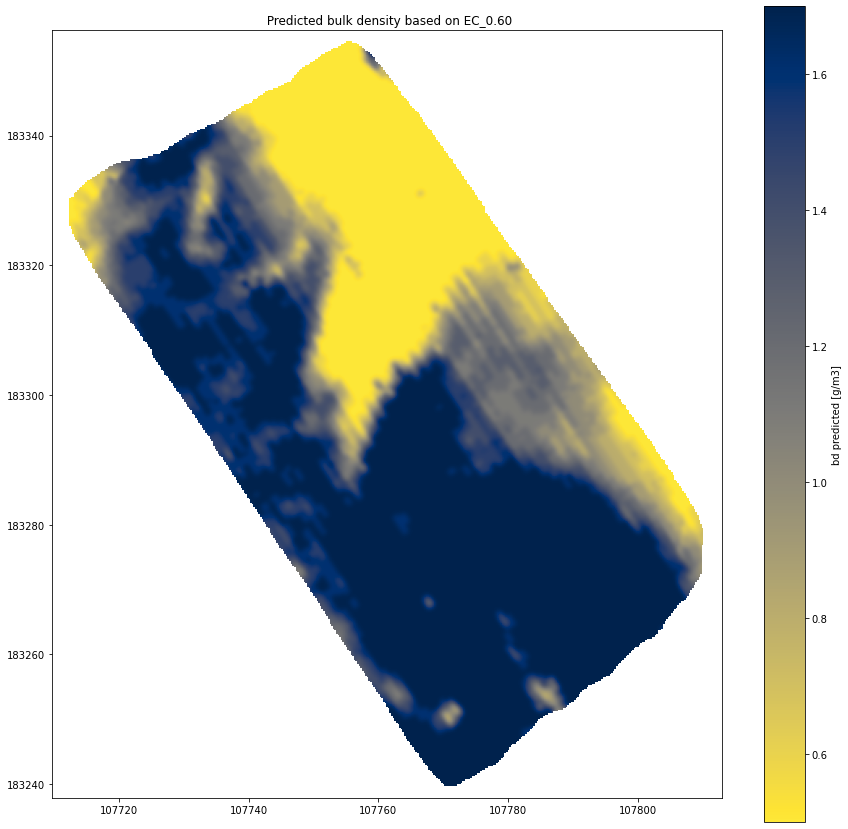

In [133]:
# 5.3: Predicting bulk density for an inverted slice
# ---------------------------------------------------

b_pred_in = inv_df.copy() # If needed, you can replace ds.copy with another dataframe

# Set the dataframe column name that holds the EC values.
# for the inverted EC values, the column names depend on the boundaries you have
# set. 
ec_colname = 'EC_0.60' # select the appropriate EC column 

# Here you set the fixed values for sand, clay content, bulk density and 
# water_ec. In the example, the average values are taken from the sampled data
# (dataframe `ds`, but you can of course modify this as you wish.
vwc_f = ds['vwc [%]'].mean()  
sand_f = ds['sand [%]'].mean()
clay_f = ds['clay [%]'].mean() 
water_ec_f = ds['hydra_ecp [mS/m]'].mean() 

# export output as GeoTIF and csv-file
export_output = True
filename = 'survey_bdens_predict'

# ******************************************************************** #

bulk_dens_predicted = []

for index, row in b_pred_in.iterrows():
    bulk_ec = row[ec_colname]
    vwc = vwc_f
    sand = sand_f
    clay = clay_f
    water_ec = water_ec_f
    bd_pred = predict_bd(bulk_ec, vwc, sand, clay, water_ec)
    bulk_dens_predicted.append(bd_pred)

b_pred_in['bd_pred [%]'] = bulk_dens_predicted

fig, axes = plt.subplots(figsize=[15, 15])
title = f' Predicted bulk density based on {ec_colname}'

data_grid = interpolate(inv_df['x'], inv_df['y'], bulk_dens_predicted, cell_size, smooth_s = 1.5)
extent = data_grid['extent']
im = axes.imshow(data_grid['grid'], origin='lower', 
                extent=(extent['x_min'],
                        extent['x_max'],
                        extent['y_min'], 
                        extent['y_max']),
                        cmap = 'cividis_r')
cbar = fig.colorbar(im, ax=axes)
cbar.set_label('bd predicted [g/m3]')
axes.set_title(title)

if export_output:
    b_pred_in.to_csv(f'{filename}.csv')
    export_grid(data_grid, filename=filename)